In [1]:
%pip install captcha 
%pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
%pip install keras


import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

!pip install "opencv-python-headless<4.3"

import itertools

import os

import numpy as np
from random import random, randint, choices

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt
import cv2

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


'apt' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


C:\Users\KARAN\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
alphabet_all = list('qwertyuiopasdfghjklzxcvbnm123456789QWERTYUIOPLKJHGFDSAZXCVBNM')
alphabet = list('qwertyuiopasdfghjklzxcvbnm123456789')#QWERTYUIOPLKJHGFDSAZXCVBNM')
num_alphabet = len(alphabet)
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(alphabet_all, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [3]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 35
IMG_ROW, IMG_COLS = 50, 135

# Non-configs
PATH = 'C:\\Users\\KARAN\\Desktop\\1l'
DATA_PATH = os.path.join(PATH, 'train')

In [4]:
def load_data(path, test_split=0.2):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                for i in range(NUM_OF_LETTERS):
                    label[i, alphabet.index(flr[i].lower())] = 1
#                 label = np.zeros((50, 1))
#                 for i in range(5):
#                     label[i*5+int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [5]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH,100000, NUM_OF_LETTERS, IMG_COLS, IMG_ROW)


Generating Dataset
Finished Data Generation


In [6]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)
x_train[0]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 100000 (train=80004, test=19996)


In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(80004, 25, 67, 1)
(80004, 5, 31)
(19996, 25, 67, 1)
(19996, 5, 31)


In [8]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [9]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [10]:
input_layer = Input((25, 67, 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
# out = Dense(num_alphabet*5, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=out)

In [11]:
# model_path = os.path.join(save_dir, model_name)
# model = keras.models.load_model(model_path)

In [12]:
# initiate Adam optimizer

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 67, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 67, 32)   832         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 67, 32)   25632       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 12, 33, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [13]:
hist_train_loss_digit = {i:[] for i in range(5)}
hist_test_loss_digit = {i:[] for i in range(5)}

hist_train_acc_digit = {i:[] for i in range(5)}
hist_test_acc_digit = {i:[] for i in range(5)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [14]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [15]:
history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test)
                   )

Epoch 1/35
626/626 [==============================] - 362s 576ms/step - loss: 0.7374 - digit0_loss: 0.1473 - digit1_loss: 0.1477 - digit2_loss: 0.1473 - digit3_loss: 0.1479 - digit4_loss: 0.1473 - digit0_accuracy: 0.0376 - digit1_accuracy: 0.0366 - digit2_accuracy: 0.0384 - digit3_accuracy: 0.0365 - digit4_accuracy: 0.0366 - val_loss: 0.7079 - val_digit0_loss: 0.1416 - val_digit1_loss: 0.1414 - val_digit2_loss: 0.1415 - val_digit3_loss: 0.1417 - val_digit4_loss: 0.1417 - val_digit0_accuracy: 0.0373 - val_digit1_accuracy: 0.0372 - val_digit2_accuracy: 0.0382 - val_digit3_accuracy: 0.0360 - val_digit4_accuracy: 0.0385
Epoch 2/35
626/626 [==============================] - 363s 579ms/step - loss: 0.7131 - digit0_loss: 0.1425 - digit1_loss: 0.1427 - digit2_loss: 0.1426 - digit3_loss: 0.1427 - digit4_loss: 0.1426 - digit0_accuracy: 0.0378 - digit1_accuracy: 0.0363 - digit2_accuracy: 0.0370 - digit3_accuracy: 0.0373 - digit4_accuracy: 0.0376 - val_loss: 0.7077 - val_digit0_loss: 0.1416 - val_

In [16]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()



    # Plot training & validation loss values
    
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

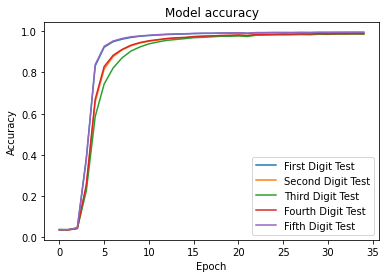

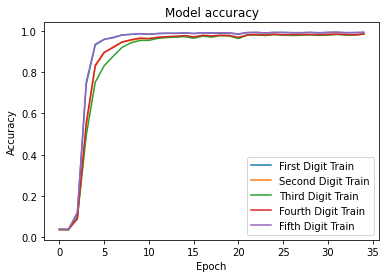

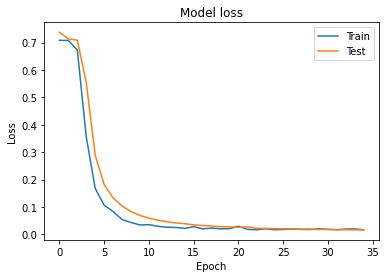

In [17]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [18]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\KARAN\Desktop\1l\saved_models\keras_cifar10_trained_model.h5 


In [19]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))

2501/2501 [==============================] - 73s 29ms/step - loss: 0.0028 - digit0_loss: 3.1566e-04 - digit1_loss: 7.3148e-04 - digit2_loss: 7.2973e-04 - digit3_loss: 6.8954e-04 - digit4_loss: 3.3648e-04 - digit0_accuracy: 0.9986 - digit1_accuracy: 0.9973 - digit2_accuracy: 0.9975 - digit3_accuracy: 0.9973 - digit4_accuracy: 0.9987
Train loss:     0.001054
Train accuracy: 98.94


In [20]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

625/625 [==============================] - 18s 29ms/step - loss: 0.0171 - digit0_loss: 0.0020 - digit1_loss: 0.0045 - digit2_loss: 0.0045 - digit3_loss: 0.0039 - digit4_loss: 0.0022 - digit0_accuracy: 0.9934 - digit1_accuracy: 0.9846 - digit2_accuracy: 0.9846 - digit3_accuracy: 0.9857 - digit4_accuracy: 0.9932
Test loss:     0.006412
Test accuracy: 94.29
